# Analisys of tweets about LGBT 

This is an analysys based on 15000 tweets about what occurs the most and what emotions writing about LGBT seems to creating 

In [ ]:
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import snscrape.modules.twitter as sntwitter
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import pandas as pd
import text2emotion as te
import ast

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

## Scrapping Tweets

In [ ]:
# Creating list to append tweet data 
tweets_list = []

# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('LGBT').get_items()): #declare a username 
    if i>15000: #number of tweets you want to scrape
        break
    tweets_list.append([tweet.date, tweet.id, tweet.rawContent, tweet.url]) #declare the attributes to be returned

In [ ]:
# Saving tweets to csv files
tweets_df = pd.DataFrame(tweets_list, columns=['date','content'])
tweets_df.to_csv('adrewTate_tweets.csv', index=False)

In [3]:
tweets_df = pd.read_csv('adrewTate_tweets.csv', parse_dates=['date'])

## Lemmatization

At this point we need to simplify and make our tweets usable, to do that we are going to: 
- extracti twitter mentions
- split sentence into a array of words
- making everything lowercase
- lemmatized words (eg. "running" is turning into "run")

In [4]:
tweets_df['content'] = tweets_df['content'].apply(lambda x: x.lower())

lemmatizer = WordNetLemmatizer()

tweets_df_lemmatized = tweets_df.copy()

stop_words = stopwords.words('english')

def lemmatize_sentence(sentence):
    words_to_remove = re.findall(r'@\w+|https://\S+', sentence)
    word_list = sentence.split()
    filtered_words = [word for word in word_list if word not in words_to_remove]
    new_text = ' '.join(filtered_words)
    sentence_tokens = word_tokenize(new_text.lower())
    stop_words = stopwords.words('english')
    stop_words.extend(['#', ',','\'','`'])
    filtered_tokens = [token for token in sentence_tokens if token not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    return lemmatized_tokens

tweets_df_lemmatized['content'] = tweets_df_lemmatized['content'].apply(lambda x: lemmatize_sentence(x))

### We are creating a dataset where every tweet will have each own level of positivity/negativity

In [5]:
tweets_df_compound = tweets_df_lemmatized.copy()

sid = SentimentIntensityAnalyzer()

tweets_df_compound['Compound'] = tweets_df_compound['content'].apply(lambda x: sid.polarity_scores(' '.join(x))['compound'])

In [6]:
max_compound = tweets_df_compound['Compound'].max()
min_compound = tweets_df_compound['Compound'].min()
print("max: ", max_compound, "min: ",min_compound)

max:  0.9921 min:  -0.9758


In [7]:

tweets_df_vadered = tweets_df_lemmatized.copy()
sid = SentimentIntensityAnalyzer()

tweets_df_vadered['Opinion'] = tweets_df_vadered['content'].apply(lambda x: sid.polarity_scores(' '.join(x)))
tweets_df_vadered['Opinion'] = tweets_df_vadered['Opinion'].apply(lambda x: 'positive' if x['compound'] >= 0.2 else 'negative' if x['compound'] <= -0.2 else 'neutral')

In [8]:
tweets_df_emotioned = tweets_df_lemmatized.copy()

tweets_df_emotioned['Emotion'] = tweets_df_emotioned['content'].apply(lambda x: te.get_emotion(' '.join(x)))

print(tweets_df_emotioned['Emotion'][0])

{'Happy': 0.22, 'Angry': 0.11, 'Surprise': 0.11, 'Sad': 0.22, 'Fear': 0.33}


In [9]:
tweets_df_emotioned['emotion_max'] = tweets_df_emotioned['Emotion'].apply(lambda x: max(x, key=x.get) if x[max(x, key=x.get)] != 0 else 'noemotions')

In [10]:
tweets_df_emotioned.to_csv('text-query-tweets-emotioned.csv', sep=',', index=False)

In [11]:
tweets_df_emotioned = pd.read_csv('text-query-tweets-emotioned.csv', parse_dates=['date'])

# Main Analysis

In [12]:
tweets_list_positive = []
tweets_list_negative = []

tweets_list_happy = []
tweets_list_angry = []
tweets_list_sad = []
tweets_list_fear = []
tweets_list_surprise = []

In [ ]:
for index,row in tweets_df_vadered.iterrows():
    if row['Opinion'] == 'positive':
        tweets_list_positive.extend(row['content'])
    elif row['Opinion'] == 'negative':
        tweets_list_negative.extend(row['content'])

for index,row in tweets_df_emotioned.iterrows():
    if row['emotion_max'] == 'Happy':
        tweets_list_happy.extend(ast.literal_eval(row['content']))
        print(tweets_list_happy)
    elif row['emotion_max'] == 'Angry':
        tweets_list_angry.extend(ast.literal_eval(row['content']))
    elif row['emotion_max'] == 'Sad':
        tweets_list_sad.extend(ast.literal_eval(row['content']))
    elif row['emotion_max'] == 'Fear':
        tweets_list_fear.extend(ast.literal_eval(row['content']))
    elif row['emotion_max'] == 'Surprise':
        tweets_list_surprise.extend(ast.literal_eval(row['content']))     

print(tweets_list_angry)        


<AxesSubplot:xlabel='frequency', ylabel='word'>

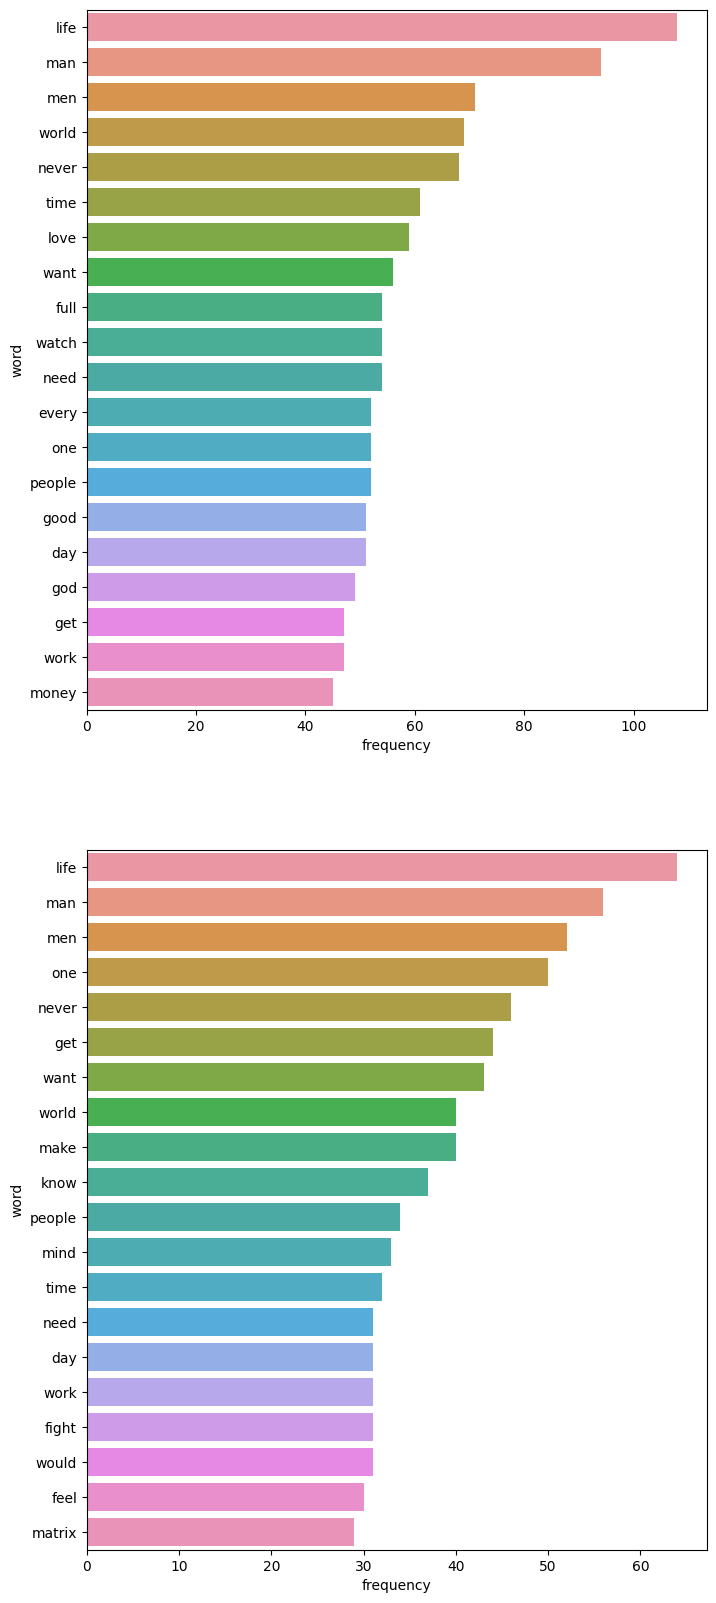

In [14]:
stop_words = stopwords.words('english')
stop_words.extend(['.',',','!',',','`','\'','?',':','\'s','&',';','n\'t','(',')','\``','"',"'",'\'\'','’','...','``','%','@','-','u','“','”'])

new_tokens_positive =[t for t in tweets_list_positive if t not in stop_words]

counted_positive = Counter(new_tokens_positive)

word_freq_positive = pd.DataFrame(counted_positive.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)

new_tokens_negative =[t for t in tweets_list_negative if t not in stop_words]

counted_negative = Counter(new_tokens_negative)

word_freq_negative = pd.DataFrame(counted_negative.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
fig, axes = plt.subplots(2,1,figsize=(8,20))
sns.barplot(ax=axes[0],x='frequency',y='word',data=word_freq_positive.head(20))
sns.barplot(ax=axes[1],x='frequency',y='word',data=word_freq_negative.head(20))

### summary 1

There are many similarities between the most used words in positive and negative tweets about the LGBT, the most used in both cases is life, the least in positive is money and in negative is matrix.

In [15]:
new_tokens_happy =[t for t in tweets_list_happy if t not in stop_words]
new_tokens_angry =[t for t in tweets_list_angry if t not in stop_words]
new_tokens_sad =[t for t in tweets_list_sad if t not in stop_words]
new_tokens_fear =[t for t in tweets_list_fear if t not in stop_words]
new_tokens_surprise =[t for t in tweets_list_surprise if t not in stop_words]

counted_happy = Counter(new_tokens_happy)
counted_angry = Counter(new_tokens_angry)
counted_sad = Counter(new_tokens_sad)
counted_fear = Counter(new_tokens_fear)
counted_surprise = Counter(new_tokens_surprise)

word_freq_happy = pd.DataFrame(counted_happy.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
word_freq_angry = pd.DataFrame(counted_angry.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
word_freq_sad = pd.DataFrame(counted_sad.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
word_freq_fear = pd.DataFrame(counted_fear.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
word_freq_surprise = pd.DataFrame(counted_surprise.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)


<AxesSubplot:xlabel='frequency', ylabel='word'>

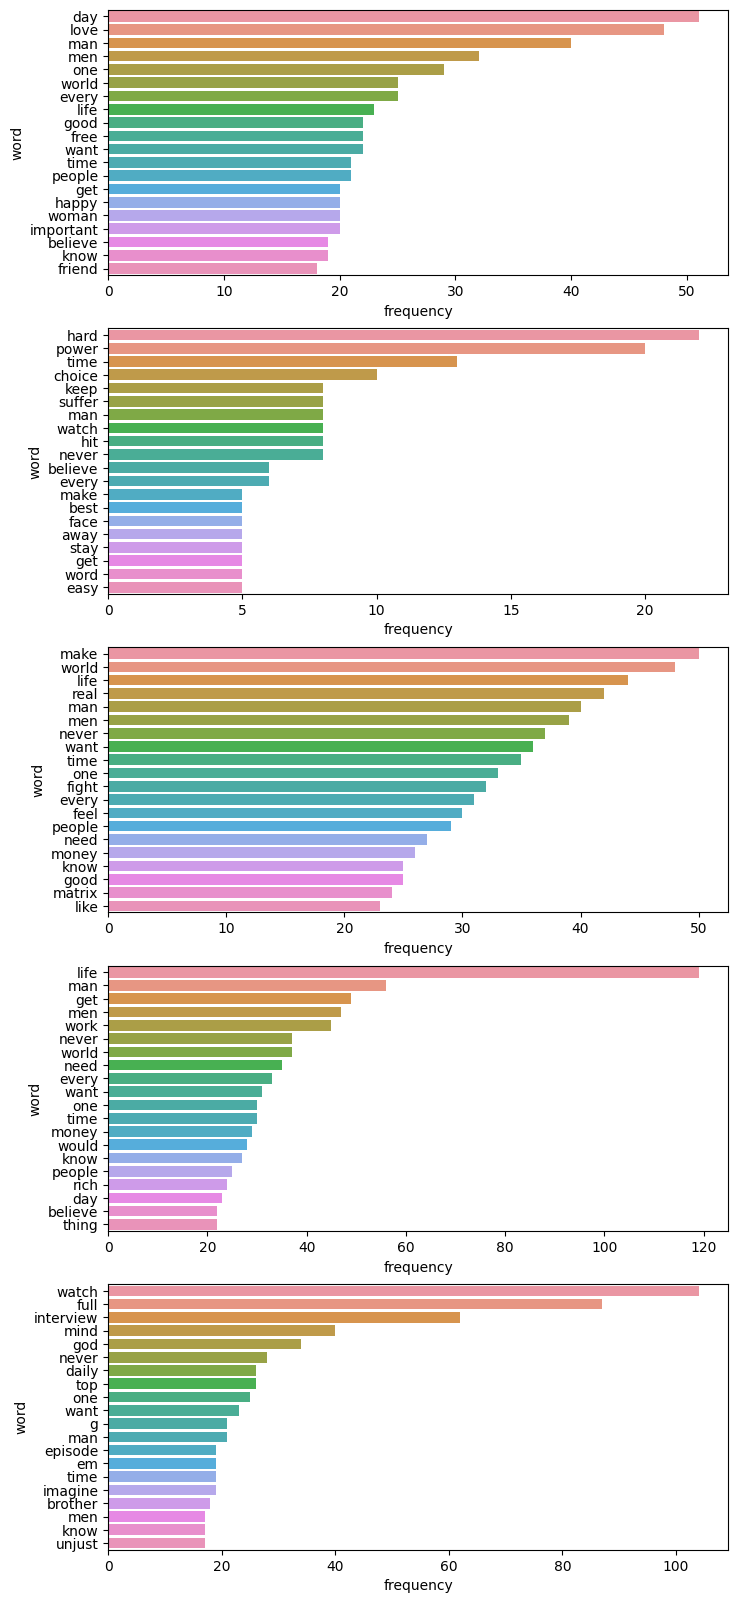

In [16]:
fig, axes = plt.subplots(5,1,figsize=(8,20))
sns.barplot(ax=axes[0],x='frequency',y='word',data=word_freq_happy.head(20),)
sns.barplot(ax=axes[1],x='frequency',y='word',data=word_freq_angry.head(20))
sns.barplot(ax=axes[2],x='frequency',y='word',data=word_freq_sad.head(20))
sns.barplot(ax=axes[3],x='frequency',y='word',data=word_freq_fear.head(20))
sns.barplot(ax=axes[4],x='frequency',y='word',data=word_freq_surprise.head(20))

### summary 2 

This time we splitted our tweets to what emotions is derived from it, we are considering:
- Happiness 
- Anger
- Sadness
- Fear
- Surprise

And there is more of a diffrence now, from the top the most used words were: day, hard, make, life, watch. The most intresting plot is for sure the one that about Sadness because the frequency on each of the words is really similar.